In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict
from ortools.linear_solver.pywraplp import Solver
from scipy.special import expit
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests


In [2]:
# Simulation parameters
MONTE_CARLO_ROUNDS = 10000

# Plot display parameters
ELO_SPACING = 20


In [3]:
# A description of result tiers and points for each tier (in a single GP leg)
tiers = ["winner", "runner-up", "semifinalist", "group runner-up", "group 3rd place", "group last"]
points = [13, 10, 7, 4, 2, 0]
max_points = max(points)

# A dict mapping tier to points received
tier_to_points = {tiers[i]: points[i] for i in range(len(tiers))}

# An array mapping index in leg standings to points received
place_to_points = [13, 10] + [7] * 2 + [4] * 4 + [2] * 4 + [0] * 4


In [4]:
name_to_rating = {
    "Ding Liren": 2799.0,
    "Levon Aronian": 2785,
    "Wesley So": 2778,
    "Shakhriyar Mamedyarov": 2771.2,
    "Anish Giri": 2772.8,
    "Richard Rapport": 2776.4,
    "Maxime Vachier-Lagrave": 2757.8,
    "Alexander Grischuk": 2742,
    "Leinier Dominguez": 2756,
    "Hikaru Nakamura": 2750,
    "Nikita Vitiugov": 2724.2,
    "Dmitry Andreikin": 2729.4,
    "Andrey Esipenko": 2723,
    "Vidit Gujrathi": 2722.6,
    "Pentala Harikrishna": 2705.2,
    "Yu Yangyi": 2710.4,
    "Daniil Dubov": 2711,
    "Vladimir Fedoseev": 2700.8,
    "Sam Shankland": 2709.2,
    "Radoslaw Wojtaszek": 2696.2,
    "Alexei Shirov": 2689.2,
    "Alexandr Predke": 2687.6,
    "Grigoriy Oparin": 2674.0,
    "Vincent Keymer": 2654.5,
    "Etienne Bacrot": 2637.8,
    "Amin Tabatabaei": 2632.4,
}
hikaru = "Hikaru Nakamura"


In [5]:
# Probabilities taken from https://chance.amstat.org/2020/09/chess/

prob_draw = lambda rwhite, rblack: expit(
    -1.627 + 0.0006955 * rwhite - 0.004668 * abs(rwhite - rblack)
)
prob_beats = lambda ra, rb: 1 / (1 + 10 ** ((rb - ra) / 400))
prob_win = lambda rwhite, rblack: prob_beats(rwhite, rblack) - prob_draw(rwhite, rblack) / 2


In [6]:
def sim_game(elo1, elo2):
    pdraw1 = prob_draw(elo1, elo2)
    pbeats1 = prob_beats(elo1, elo2)
    pwin1 = pbeats1 - pdraw1 / 2

    rand = random.random()
    if rand <= pwin1:
        return 1
    elif rand > pwin1 + pdraw1:
        return 0
    return 1/2


def sim_tiebreak(elo1, elo2):
    points = 0
    points += sim_game(elo1, elo2)*2-1
    points -= sim_game(elo2, elo1)*2-1
    return points


def sim_group(inds, elos, fixed_results=None):
    n = len(inds)
    points = [0] * n
    wins = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            res1 = fixed_results and fixed_results[i][j]
            if res1 is None:
                res1 = sim_game(elos[inds[i]], elos[inds[j]])
            points[i] += res1
            wins[i] += int(res1 == 1)
            points[j] += 1 - res1
            wins[j] += int(res1 == 0)

            res2 = fixed_results and fixed_results[j][i]
            if res2 is None:
                res2 = sim_game(elos[inds[j]], elos[inds[i]])
            points[i] += 1 - res2
            wins[i] += int(res2 == 0)
            points[j] += res2
            wins[j] += int(res2 == 1)
    inds_rankings = list(sorted(range(n), key=lambda i: points[i], reverse=True))
    tiebreak = int(points[inds_rankings[0]] != points[inds_rankings[1]])
    while tiebreak == 0:
        ind0, ind1 = inds_rankings[0], inds_rankings[1]
        tiebreak = sim_tiebreak(elos[inds[ind0]], elos[inds[ind1]])
        if tiebreak < 0:
            inds_rankings[0], inds_rankings[1] = inds_rankings[1], inds_rankings[0]
    return [inds[i] for i in inds_rankings], points, wins


def sim_leg(elos, groups=None, fixed_group_results=None):
    n = len(elos)

    if groups is None:
        rand_inds = np.array(range(n))
        np.random.shuffle(rand_inds)
        groups = [list(g) for g in np.split(rand_inds, 4)]
    if fixed_group_results is None:
        fixed_group_results = [None] * len(groups)
    
    points = [0] * n
    wins = [0] * n

    def update_totals(g, p, w):
        for i, player_idx in enumerate(g):
            points[player_idx] += p[i]
            wins[player_idx] += w[i]
    
    group_results = []
    for i, group in enumerate(groups):
        results, group_points, group_wins = sim_group(group, elos, fixed_group_results[i])
        update_totals(group, group_points, group_wins)
        group_results.append(results)

    rev_standings = []
    for group_place in range(3, 0, -1):
        for group_res in group_results:
            rev_standings.append(group_res[group_place])

    semis = [group_res[0] for group_res in group_results]
    semi1_res, semi1_points, semi1_wins = sim_group(semis[:2], elos)
    update_totals(semis[:2], semi1_points, semi1_wins)
    semi2_res, semi2_points, semi2_wins = sim_group(semis[2:], elos)
    update_totals(semis[2:], semi2_points, semi2_wins)
    rev_standings.append(semi1_res[1])
    rev_standings.append(semi2_res[1])
    finals = [semi1_res[0], semi2_res[0]]
    f_res, f_points, f_wins = sim_group(finals, elos)
    update_totals(finals, f_points, f_wins)
    rev_standings.append(f_res[1])
    rev_standings.append(f_res[0])

    leg_points = [0] * n
    for i, player in enumerate(reversed(rev_standings)):
        leg_points[player] = place_to_points[i]

    return leg_points, points, wins


In [7]:
grand_prix_page = requests.get("https://www.chess.com/article/view/fide-grand-prix-2022")
grand_prix_soup = BeautifulSoup(grand_prix_page.text, "lxml")


In [8]:
# Leg 1

leg1_players_soup = grand_prix_soup.select(".standings_table")[2]
headers = []
for h in leg1_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg1_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg1_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg1_players_df = leg1_players_df.drop(["Fed"], axis=1)
leg1_players_df["Player"] = leg1_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg1_players_df["Rating"] = leg1_players_df["Player"].apply(lambda n: name_to_rating[n])

leg1_players_df["Leg 1 Points"] = pd.Series([4, 10, 2, 7, 7, 13, 4, 2, 3, 3, 2, 0, 4, 0, 0, 0])
leg1_games = [
    [1/2, 0, 1/2, 1, 1, 1], # Wesley So
    [1/2, 1/2, 1, 1/2, 1, 1, 1, 1/2, 1/2, 1/2], # Levon Aronian
    [1/2, 0, 1/2, 1/2, 1/2, 1], # Alexander Grischuk
    [0, 1/2, 1, 1, 1/2, 1/2, 0, 1/2], # Richard Rapport
    [1/2, 0, 1/2, 1, 1, 1, 0, 1/2], # Leinier Dominguez
    [1, 1/2, 1/2, 1, 1/2, 1/2, 1, 1/2, 1/2, 1/2], # Hikaru Nakamura
    [0, 1/2, 1/2, 1/2, 1, 1], # Andrey Esipenko
    [1/2, 0, 1/2, 1/2, 1/2, 1/2], # Pentala Harikrishna
    [0, 1/2, 1, 1/2, 1/2, 1/2], # Vidit Gujrathi
    [1/2, 1/2, 0, 1/2, 1/2, 1], # Daniil Dubov
    [0, 0, 1/2, 1/2, 1, 1], # Vladimir Fedoseev
    [0, 0, 0, 1/2, 1/2, 1/2], # Alexei Shirov	
    [1, 1/2, 1/2, 1/2, 1/2, 1/2], # Radoslaw Wojtaszek
    [1/2, 1/2, 1/2, 1/2, 0, 0], # Grigoriy Oparin
    [0, 0, 1/2, 0, 1/2, 1/2], # Vincent Keymer
    [1/2, 1/2, 0, 0, 1/2, 0], # Etienne Bacrot
]
leg1_players_df["Leg 1 Game Points"] = pd.Series([sum(g) for g in leg1_games])
leg1_players_df["Leg 1 Wins"] = pd.Series([sum([int(r == 1) for r in g]) for g in leg1_games])

leg1_players = leg1_players_df["Player"]

leg1_players_df


,Player,Rating,Leg 1 Points,Leg 1 Game Points,Leg 1 Wins
0,Wesley So,2778.0,4,4.0,3
1,Levon Aronian,2785.0,10,7.0,4
2,Alexander Grischuk,2742.0,2,3.0,1
3,Richard Rapport,2776.4,7,4.0,2
4,Leinier Dominguez,2756.0,7,4.5,3
5,Hikaru Nakamura,2750.0,13,6.5,3
6,Andrey Esipenko,2723.0,4,3.5,2
7,Pentala Harikrishna,2705.2,2,2.5,0
8,Vidit Gujrathi,2722.6,3,3.0,1
9,Daniil Dubov,2711.0,3,3.0,1


In [9]:
# Leg 2 (simulated)

leg2_players_soup = grand_prix_soup.select(".standings_table")[5]
headers = []
for h in leg2_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg2_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg2_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg2_players_df["Player"] = leg2_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg2_players_df = leg2_players_df.drop(["Fed"], axis=1)
leg2_players_df["Rating"] = leg2_players_df["Player"].apply(lambda n: name_to_rating[n])

round2_elos = [float(elo) for elo in leg2_players_df["Rating"]]
leg2_players_df["Leg 2 Points"] = pd.Series([10, 7, 4, 0, 13, 7, 4, 0, 4, 0, 4, 2, 0, 2, 2, 2])
leg2_games = [
    [1/2, 1/2, 1/2, 1, 1, 1/2, 1/2, 1/2, 1/2, 0], # Dmitry Andreikin
    [1, 1/2, 1, 1/2, 1/2, 1/2, 1/2, 1/2], # Anish Giri
    [1/2, 1/2, 1/2, 1/2, 1/2, 1/2], # Shakhriyar Mamedyarov
    [0, 1/2, 0, 1/2, 1/2, 1/2], # Alexander Grischuk
    [1, 1, 1/2, 1/2, 1/2, 1/2, 1, 1/2, 1/2, 1], # Richard Rapport
    [1/2, 1, 1/2, 1/2, 1/2, 1/2, 0, 1/2], # Maxime Vachier-Lagrave
    [0, 1/2, 1/2, 1/2, 1, 1/2], # Nikita Vitiugov
    [1/2, 1/2, 1/2, 0, 0, 1/2], # Pentala Harikrishna
    [0, 0, 1, 1/2, 1, 1/2], # Vidit Gujrathi
    [1/2, 1/2, 1/2, 0, 1/2, 1/2], # Yu Yangyi
    [1/2, 1/2, 1/2, 1/2, 1, 1/2], # Sam Shankland
    [1/2, 1/2, 0, 1/2, 1, 0], # Vladimir Fedoseev	
    [1/2, 1/2, 0, 1/2, 0, 1], # Alexei Shirov
    [1/2, 0, 1/2, 1/2, 1/2, 1], # Alexandr Predke
    [0, 1/2, 1/2, 1/2, 1/2, 1], # Amin Tabatabaei
    [1/2, 0, 1/2, 1/2, 1/2, 1/2], # Etienne Bacrot
]
leg2_players_df["Leg 2 Game Points"] = pd.Series([sum(g) for g in leg2_games])
leg2_players_df["Leg 2 Wins"] = pd.Series([sum([int(r == 1) for r in g]) for g in leg2_games])

leg2_players = leg2_players_df["Player"]

leg2_players_df


,Player,Rating,Leg 2 Points,Leg 2 Game Points,Leg 2 Wins
0,Dmitry Andreikin,2729.4,10,5.5,2
1,Anish Giri,2772.8,7,5.0,2
2,Shakhriyar Mamedyarov,2771.2,4,3.0,0
3,Alexander Grischuk,2742.0,0,2.0,0
4,Richard Rapport,2776.4,13,7.0,4
5,Maxime Vachier-Lagrave,2757.8,7,4.0,1
6,Nikita Vitiugov,2724.2,4,3.0,1
7,Pentala Harikrishna,2705.2,0,2.0,0
8,Vidit Gujrathi,2722.6,4,3.0,2
9,Yu Yangyi,2710.4,0,2.5,0


In [10]:
# Leg 3 (simulated)

leg3_players_soup = grand_prix_soup.select(".standings_table")[8]
headers = []
for h in leg3_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg3_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg3_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg3_players_df["Player"] = leg3_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg3_players_df.loc[leg3_players_df["Player"] == "Dmitry Andreikin", "Player"] = "Andrey Esipenko"
leg3_players_df = leg3_players_df.drop(["Fed"], axis=1)
leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])

round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
# leg3_players_df["Leg 3 Points"] = pd.Series([])

leg3_players = leg3_players_df["Player"]

leg3_groups = [[2, 6, 8, 13], [3, 5, 9, 14], [1, 4, 11, 12], [7, 0, 10, 15]]
leg3_groups_players = [
    [leg3_players_df.loc[idx, "Player"] for idx in group] for group in leg3_groups
]

leg3_fixed_games = [
    [
        ("Andrey Esipenko", "Grigoriy Oparin", 1/2),
        ("Levon Aronian", "Hikaru Nakamura", 1),
        ("Levon Aronian", "Grigoriy Oparin", 1/2),
        ("Hikaru Nakamura", "Andrey Esipenko", 1/2),
        ("Grigoriy Oparin", "Hikaru Nakamura", 1/2),
        ("Andrey Esipenko", "Levon Aronian", 1/2),
    ],
    [
        ("Vincent Keymer", "Shakhriyar Mamedyarov", 1/2),
        ("Daniil Dubov", "Leinier Dominguez", 0),
        ("Daniil Dubov", "Shakhriyar Mamedyarov", 1/2),
        ("Leinier Dominguez", "Vincent Keymer", 1/2),
        ("Shakhriyar Mamedyarov", "Leinier Dominguez", 1/2),
        ("Vincent Keymer", "Daniil Dubov", 1),
    ],
    [
        ("Sam Shankland", "Wesley So", 1/2),
        ("Alexandr Predke", "Maxime Vachier-Lagrave", 1),
        ("Alexandr Predke", "Wesley So", 1/2),
        ("Maxime Vachier-Lagrave", "Sam Shankland", 1/2),
        ("Wesley So", "Maxime Vachier-Lagrave", 1/2),
        ("Sam Shankland", "Alexandr Predke", 1/2),
    ],
    [
        ("Anish Giri", "Yu Yangyi", 1/2),
        ("Nikita Vitiugov", "Amin Tabatabaei", 1),
        ("Nikita Vitiugov", "Yu Yangyi", 1/2),
        ("Amin Tabatabaei", "Anish Giri", 1/2),
        ("Yu Yangyi", "Amin Tabatabaei", 1/2),
        ("Anish Giri", "Nikita Vitiugov", 1/2),
    ],
]
leg3_fixed_games = [{(w, b): r for w, b, r in group_games} for group_games in leg3_fixed_games]

leg3_fixed_results = []
for i, players in enumerate(leg3_groups_players):
    crosstable = []
    for player1 in players:
        crosstable.append([])
        for player2 in players:
            crosstable[-1].append(leg3_fixed_games[i].get((player1, player2)))
    leg3_fixed_results.append(crosstable)

print("Leg 3 Groups:")
for i, group in enumerate(leg3_groups):
    elos = [leg3_players_df["Rating"][p] for p in group]
    print(f"\tGroup {i+1} (avg. rating: {sum(elos)/len(elos):.1f}):")
    for gi, p in enumerate(group):
        print(f"\t - {leg3_players_df['Player'][p]} ({elos[gi]})")
    print("\tGroup Results:")
    print("\t", leg3_fixed_results[i])
    print("")

leg3_players_df


Leg 3 Groups:
	Group 1 (avg. rating: 2733.0):
	 - Levon Aronian (2785.0)
	 - Hikaru Nakamura (2750.0)
	 - Andrey Esipenko (2723.0)
	 - Grigoriy Oparin (2674.0)
	Group Results:
	 [[None, 1, None, 0.5], [None, None, 0.5, None], [0.5, None, None, 0.5], [None, 0.5, None, None]]

	Group 2 (avg. rating: 2723.2):
	 - Shakhriyar Mamedyarov (2771.2)
	 - Leinier Dominguez (2756.0)
	 - Daniil Dubov (2711.0)
	 - Vincent Keymer (2654.5)
	Group Results:
	 [[None, 0.5, None, None], [None, None, None, 0.5], [0.5, 0, None, None], [0.5, None, 1, None]]

	Group 3 (avg. rating: 2733.2):
	 - Wesley So (2778.0)
	 - Maxime Vachier-Lagrave (2757.8)
	 - Sam Shankland (2709.2)
	 - Alexandr Predke (2687.6)
	Group Results:
	 [[None, 0.5, None, None], [None, None, 0.5, None], [0.5, None, None, 0.5], [0.5, 1, None, None]]

	Group 4 (avg. rating: 2709.9):
	 - Nikita Vitiugov (2724.2)
	 - Anish Giri (2772.8)
	 - Yu Yangyi (2710.4)
	 - Amin Tabatabaei (2632.4)
	Group Results:
	 [[None, None, 0.5, 1], [0.5, None, 0.5, 

,Player,Rating
0,Anish Giri,2772.8
1,Wesley So,2778.0
2,Levon Aronian,2785.0
3,Shakhriyar Mamedyarov,2771.2
4,Maxime Vachier-Lagrave,2757.8
5,Leinier Dominguez,2756.0
6,Hikaru Nakamura,2750.0
7,Nikita Vitiugov,2724.2
8,Andrey Esipenko,2723.0
9,Daniil Dubov,2711.0


In [11]:
def sim_grand_prix():
    leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])
    round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
    leg_points, game_points, wins = sim_leg(
        round3_elos, groups=leg3_groups, fixed_group_results=leg3_fixed_results
    )
    leg3_players_df["Leg 3 Points"] = pd.Series(leg_points)
    leg3_players_df["Leg 3 Game Points"] = pd.Series(game_points)
    leg3_players_df["Leg 3 Wins"] = pd.Series(wins)

    leg2_cum_df = pd.merge(leg1_players_df, leg2_players_df, on="Player", how="outer")
    final_df = pd.merge(leg2_cum_df, leg3_players_df, on="Player", how="outer")
    final_df["Rating"] = final_df["Player"].apply(lambda n: name_to_rating[n])

    final_df["1st Places"] = 0
    final_df["2nd Places"] = 0

    for metric in ["Points", "Game Points", "Wins"]:
        for leg in [1, 2, 3]:
            final_df[f"Leg {leg} {metric}"] = final_df[f"Leg {leg} {metric}"].fillna(0)
            final_df["1st Places"] += (
                final_df[f"Leg {leg} Points"] == tier_to_points["winner"]
            ).astype(int)
            final_df["2nd Places"] += (
                final_df[f"Leg {leg} Points"] == tier_to_points["runner-up"]
            ).astype(int)
        final_df[f"Total {metric}"] = sum(final_df[f"Leg {i} {metric}"] for i in [1, 2, 3])

    final_df = final_df.sample(frac=1).reset_index(drop=True)
    final_df = final_df.sort_values(
        by=["Total Points", "1st Places", "2nd Places", "Total Game Points", "Total Wins"],
        ascending=False,
    ).reset_index(drop=True)
    final_df.index = final_df.index + 1
    return final_df[
        ["Player", "Rating", "Leg 1 Points", "Leg 2 Points", "Leg 3 Points", "Total Points"]
    ]


100%|██████████| 11/11 [40:05<00:00, 218.66s/it]


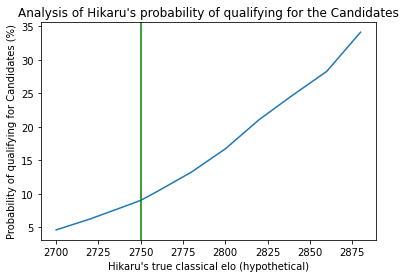

In [12]:
# Probability distribution of Hikaru candidates qualification


def prob_hikaru_qualifies(elo):
    orig_elo = name_to_rating[hikaru]
    name_to_rating[hikaru] = elo
    num_qualifies = 0
    for _ in range(MONTE_CARLO_ROUNDS):
        candidates_rows = sim_grand_prix()[:2]
        num_qualifies += int(any(row["Player"] == hikaru for _, row in candidates_rows.iterrows()))
    name_to_rating[hikaru] = orig_elo
    return num_qualifies / MONTE_CARLO_ROUNDS


hikaru_elo = np.sort(np.append(np.arange(2700, 2900, ELO_SPACING), name_to_rating[hikaru]))
candidates_prob = np.array([prob_hikaru_qualifies(elo) for elo in tqdm(hikaru_elo)])

plt.plot(hikaru_elo, candidates_prob * 100, label="Hikaru's Classical Elo (Hypothetical)")
plt.axvline(x=name_to_rating[hikaru], color="green")
plt.title("Analysis of Hikaru's probability of qualifying for the Candidates")
plt.xlabel("Hikaru's true classical elo (hypothetical)")
plt.ylabel("Probability of qualifying for Candidates (%)")
plt.savefig("hikaru_candidates_prob.png", facecolor="white")
plt.show()


In [13]:
# Average points per player

avg_final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
avg_final.index = avg_final.index + 1

print(
    "Average points by player for the simulated FIDE Grand Prix (after round 3, leg 3):"
)
avg_final


Average points by player for the simulated FIDE Grand Prix (after round 3, leg 3):


,Player,Rating,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,Richard Rapport,2776.4,7.0,13.0,0.0000,20.0000
2,Levon Aronian,2785.0,10.0,0.0,8.2901,18.2901
3,Hikaru Nakamura,2750.0,13.0,0.0,2.5306,15.5306
4,Leinier Dominguez,2756.0,7.0,0.0,6.4500,13.4500
5,Anish Giri,2772.8,0.0,7.0,5.6234,12.6234
6,Dmitry Andreikin,2729.4,0.0,10.0,0.0000,10.0000
7,Nikita Vitiugov,2724.2,0.0,4.0,5.9730,9.9730
8,Wesley So,2778.0,4.0,0.0,5.8359,9.8359
9,Maxime Vachier-Lagrave,2757.8,0.0,7.0,2.5760,9.5760
10,Shakhriyar Mamedyarov,2771.2,0.0,4.0,4.9816,8.9816


In [14]:
# Probability of qualifying for the candidates, by player

prob_final = None

cand_prob_col = "Candidates Qualification Probability (%)"

for _ in range(MONTE_CARLO_ROUNDS):
    sim = sim_grand_prix()
    if prob_final is None:
        prob_final = sim.copy(deep=True)
        prob_final[cand_prob_col] = 0
    sim.loc[:3, "num_qualified"] = 1
    sim.loc[3:, "num_qualified"] = 0
    new_prob_final = pd.merge(prob_final, sim, on=["Player", "Rating"], how="inner")
    new_prob_final[cand_prob_col] += new_prob_final["num_qualified"]
    prob_final = new_prob_final[["Player", "Rating", cand_prob_col]].copy(deep=True)

prob_final[cand_prob_col] /= MONTE_CARLO_ROUNDS
prob_final[cand_prob_col] *= 100
prob_final = prob_final.sort_values(by=cand_prob_col, ascending=False).reset_index(drop=True)
prob_final.index = prob_final.index + 1

print(
    "Each player's probability of qualifying for the candidates "
    f"(after round 3, leg 3):"
)
prob_final


Each player's probability of qualifying for the candidates (after round 3, leg 3):


,Player,Rating,Candidates Qualification Probability (%)
1,Richard Rapport,2776.4,99.53
2,Levon Aronian,2785.0,41.54
3,Leinier Dominguez,2756.0,13.97
4,Anish Giri,2772.8,11.60
5,Hikaru Nakamura,2750.0,8.90
6,Wesley So,2778.0,7.78
7,Shakhriyar Mamedyarov,2771.2,6.36
8,Nikita Vitiugov,2724.2,4.09
9,Maxime Vachier-Lagrave,2757.8,2.72
10,Andrey Esipenko,2723.0,2.21


In [15]:
# Probability of qualifying for the candidates
# if placed in a given tier

cand_prob_col = "Candidates Qualification Probability (%)"


def prob_qualifies_given_tier(tier):
    prob_final = None
    place_points = tier_to_points[tier]
    for _ in range(MONTE_CARLO_ROUNDS):
        sim = sim_grand_prix()
        if prob_final is None:
            prob_final = sim.copy(deep=True)
            prob_final[cand_prob_col] = 0
            prob_final["total_num_place"] = 0
        sim.loc[:3, "num_qualified"] = sim.loc[:3, "Leg 3 Points"] == place_points
        sim.loc[3:, "num_qualified"] = 0
        sim["num_place"] = sim["Leg 3 Points"] == place_points
        new_prob_final = pd.merge(prob_final, sim, on=["Player", "Rating"], how="inner")
        new_prob_final[cand_prob_col] += new_prob_final["num_qualified"]
        new_prob_final["total_num_place"] += new_prob_final["num_place"]
        prob_final = new_prob_final[["Player", "Rating", cand_prob_col, "total_num_place"]].copy(
            deep=True
        )

    can_div = prob_final["total_num_place"] > 0
    prob_final.loc[can_div, cand_prob_col] /= prob_final.loc[can_div, "total_num_place"] / 100
    prob_final.loc[~can_div, cand_prob_col] = np.nan
    prob_final.drop(columns=["total_num_place"], inplace=True)
    prob_final = prob_final[prob_final["Player"].isin(leg3_players)]
    prob_final = prob_final.sort_values(by=cand_prob_col, ascending=False).reset_index(drop=True)
    prob_final.index = prob_final.index + 1

    print(
        "Each player's probability of qualifying for the candidates "
        f"if they place as [{tier}] in leg 3\n"
        f"(after round 3, leg 3):"
    )
    return prob_final


In [16]:
prob_qualifies_given_tier("winner")

Each player's probability of qualifying for the candidates if they place as [winner] in leg 3
(after round 3, leg 3):


,Player,Rating,Candidates Qualification Probability (%)
1,Levon Aronian,2785.0,100.0
2,Hikaru Nakamura,2750.0,100.0
3,Leinier Dominguez,2756.0,98.678414
4,Anish Giri,2772.8,98.596201
5,Andrey Esipenko,2723.0,95.964126
6,Maxime Vachier-Lagrave,2757.8,93.165468
7,Shakhriyar Mamedyarov,2771.2,75.182482
8,Wesley So,2778.0,52.892562
9,Sam Shankland,2709.2,52.247191
10,Nikita Vitiugov,2724.2,48.124191


In [17]:
prob_qualifies_given_tier("runner-up")

Each player's probability of qualifying for the candidates if they place as [runner-up] in leg 3
(after round 3, leg 3):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,100.0
2,Levon Aronian,2785.0,65.547192
3,Leinier Dominguez,2756.0,3.364172
4,Maxime Vachier-Lagrave,2757.8,1.139601
5,Anish Giri,2772.8,0.758294
6,Sam Shankland,2709.2,0.722892
7,Andrey Esipenko,2723.0,0.623053
8,Shakhriyar Mamedyarov,2771.2,0.17301
9,Wesley So,2778.0,0.15873
10,Nikita Vitiugov,2724.2,0.138504


In [18]:
prob_qualifies_given_tier("semifinalist")

Each player's probability of qualifying for the candidates if they place as [semifinalist] in leg 3
(after round 3, leg 3):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,68.435754
2,Levon Aronian,2785.0,4.008909
3,Maxime Vachier-Lagrave,2757.8,0.184502
4,Leinier Dominguez,2756.0,0.0
5,Yu Yangyi,2710.4,0.0
6,Anish Giri,2772.8,0.0
7,Nikita Vitiugov,2724.2,0.0
8,Shakhriyar Mamedyarov,2771.2,0.0
9,Alexandr Predke,2687.6,0.0
10,Sam Shankland,2709.2,0.0


In [19]:
prob_qualifies_given_tier("group runner-up")

Each player's probability of qualifying for the candidates if they place as [group runner-up] in leg 3
(after round 3, leg 3):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,9.350824
2,Levon Aronian,2785.0,1.28327
3,Anish Giri,2772.8,0.0
4,Andrey Esipenko,2723.0,0.0
5,Leinier Dominguez,2756.0,0.0
6,Maxime Vachier-Lagrave,2757.8,0.0
7,Wesley So,2778.0,0.0
8,Shakhriyar Mamedyarov,2771.2,0.0
9,Nikita Vitiugov,2724.2,0.0
10,Sam Shankland,2709.2,0.0


In [20]:
prob_qualifies_given_tier("group 3rd place")

Each player's probability of qualifying for the candidates if they place as [group 3rd place] in leg 3
(after round 3, leg 3):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,1.345977
2,Leinier Dominguez,2756.0,0.0
3,Levon Aronian,2785.0,0.0
4,Anish Giri,2772.8,0.0
5,Alexandr Predke,2687.6,0.0
6,Wesley So,2778.0,0.0
7,Shakhriyar Mamedyarov,2771.2,0.0
8,Maxime Vachier-Lagrave,2757.8,0.0
9,Nikita Vitiugov,2724.2,0.0
10,Sam Shankland,2709.2,0.0


In [21]:
prob_qualifies_given_tier("group last")

Each player's probability of qualifying for the candidates if they place as [group last] in leg 3
(after round 3, leg 3):


,Player,Rating,Candidates Qualification Probability (%)
1,Hikaru Nakamura,2750.0,0.098555
2,Levon Aronian,2785.0,0.0
3,Wesley So,2778.0,0.0
4,Anish Giri,2772.8,0.0
5,Leinier Dominguez,2756.0,0.0
6,Shakhriyar Mamedyarov,2771.2,0.0
7,Andrey Esipenko,2723.0,0.0
8,Sam Shankland,2709.2,0.0
9,Nikita Vitiugov,2724.2,0.0
10,Maxime Vachier-Lagrave,2757.8,0.0


In [22]:
# Average points per place

avg_final = sim_grand_prix()

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix()
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.drop(["Player", "Rating"], axis=1)

print(f"Average points by standing position for the simulated FIDE Grand Prix:")
avg_final


Average points by standing position for the simulated FIDE Grand Prix:


,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,7.4577,6.9660,6.5978,21.0215
2,6.1509,7.5008,5.5149,19.1666
3,8.4120,1.0490,7.0640,16.5250
4,7.4299,1.1919,6.1859,14.8077
5,5.4771,1.8818,5.7344,13.0933
6,2.2628,4.1606,4.8085,11.2319
7,0.9924,5.8629,3.5233,10.3786
8,0.9421,5.8953,2.7174,9.5548
9,1.2895,4.3320,3.0393,8.6608
10,1.5060,3.2844,3.1444,7.9348
